# 1.Libraries

In [1]:
# Base ------------------------------------------------
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.weightstats as smw
import math
import plotly.express as px

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.1f}'.format

#plt.style.use('seaborn')
# Viz -------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Estimation and Models -------------------------------------
import statsmodels.stats.proportion as smp       # Estimation of proportions
import statsmodels.stats.weightstats as smw      # Estimation of the Mean
from statsmodels.stats.power import TTestPower   # Power of the Test

# Standard Library Imports
from pathlib import Path

# Our package
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

from plotnine import *

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# 2. Datasets

In [4]:
# MAIN DATA SET
df = pd.read_parquet('Data raw.parquet')
df.head(3)

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,description,visibility,main_photo_url
0,37.6,15.0,Autonomo,None,200 m²,0.0,Excellent condition / Renovated,Villa o villino in vendita a Mascalucia,310000,5+,Mid-range properties,Residential,3.0,3,0,NaN,Villa unifamiliare via Busoni 5 Centro Mascalucia,0.0,Full ownership,"['Balcone', 'Giardino privato']",None,Su più livelli,NaN,Single-family villa,Ampia villa con vista panoramica in via Busoni...,premium,https://pwm.im-cdn.it/image/1249030802/xxs-c.jpg
1,37.6,15.1,None,None,300 m²,0.0,Needs renovation,Villa a Ficarazzi con ampio spazio esterno e l...,329000,5+,Luxury properties,Residential,2.0,2,0,1895.0,Villa unifamiliare via Tripoli 145 95021 Aci C...,0.0,Full ownership,"['Balcone', 'Terrazza', 'Impianto tv singolo',...",G,Piano terra,0.0,Single-family villa,Composizione e dettagli rilevanti dellimmobile...,premium,https://pwm.im-cdn.it/image/1248833182/xxs-c.jpg
2,37.5,15.1,Autonomo,"Autonomo, freddo/caldo","148 m² | commerciale 174,5 m²",0.0,Excellent condition / Renovated,Zona Ognina Indipendente con garage e spazio e...,330000,4,Mid-range properties,Residential,2.0,3,0,2000.0,Villa unifamiliare via Veglia 10 Picanello Cat...,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'VideoCito...",E,2 piani: da Seminterrato a Piano terra,0.0,Single-family villa,Nella zona di Ognina esattamente in via Veglia...,premium,https://pwm.im-cdn.it/image/1247716050/xxs-c.jpg


In [6]:
# Load Market data
market = pd.read_excel('market.xlsx', sheet_name='Market')
market.head(3)

,Regions,Immobiliare.it,mydolcecasa,Idealista.it,Statista,Average
0,Trentino Alto Adige,3138,2836.8,2832,2660,2866.7
1,Valle d'Aosta,2733,2699.4,2634,2600,2666.6
2,Liguria,2546,2532.5,2500,2490,2517.1


In [7]:
Italy_df = pd.read_excel('worldcities.xlsx', sheet_name='Italy2')
Italy_df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,latmin,latmax,logmin,logmax
0,Rome,Rome,41.9,12.5,Italy,IT,ITA,Lazio,primary,2872800,1380382862,41.2,42.5,11.6,13.8
1,Milan,Milan,45.5,9.2,Italy,IT,ITA,Lombardia,admin,1366180,1380724377,44.9,46.2,8.6,10.8
2,Naples,Naples,40.8,14.2,Italy,IT,ITA,Campania,admin,966144,1380646673,40.3,41.2,13.8,15.6
3,Turin,Turin,45.1,7.7,Italy,IT,ITA,Piemonte,admin,870952,1380244627,44.3,46.1,6.6,8.9
4,Palermo,Palermo,38.1,13.4,Italy,IT,ITA,Sicilia,admin,668405,1380428434,36.7,38.8,12.4,15.6


# 3. Data Cleaning

## 3.1. Location

In [8]:
# create a boolean mask based on latitude and longitude range for Italy
italy_lat_range = (35.5, 47.1)
italy_lon_range = (6.6, 18.5)
mask = (df['latitude'].between(*italy_lat_range)) & (df['longitude'].between(*italy_lon_range))
df = df[mask]

### 3.1.1. Add Italy regions

In [9]:
regions = Italy_df[['admin_name','latmin', 'latmax', 'logmin', 'logmax']]
regions = regions.drop_duplicates()

In [10]:
# Iterate over the coordinates in your original DataFrame
for index, row in df.iterrows():
    lat = row['latitude']
    lon = row['longitude']

    # Find the region that matches the coordinate range
    matching_region = regions[
        (regions['latmin'] <= lat) &
        (regions['latmax'] >= lat) &
        (regions['logmin'] <= lon) &
        (regions['logmax'] >= lon)
    ]['admin_name']
    
   # Check if matching_region has any elements
    if not matching_region.empty:
        # Get the first element of matching_region as a string
        matching_region = matching_region.iloc[0]
    else:
        matching_region = 'Unknown'  # or any other desired value when no match is found
        
    # Assign the region to a new column in your original DataFrame
    df.at[index, 'Region'] = matching_region

In [11]:
# check there are no unknown regions
df['Region'].value_counts()

Lazio             45061
Piemonte          32948
Lombardia         31911
Sicilia           17374
Veneto            16643
Toscana           14515
Sardegna          11878
Campania          11874
Emilia-Romagna    10747
Calabria          10577
Liguria            8792
Puglia             8424
Abruzzo            2972
Name: Region, dtype: int64

## 3.2. Price per m^2

### 3.2.1. Normalize Surface

In [12]:
# Split of Surface from surface including commercial
df.loc[:, 'surface_res'] = df.surface.str.split(pat='m²', expand=True)[0]

In [13]:
df['surface_res']= df['surface_res'].str.strip()

In [14]:
# Replace commerciale with none
df.loc[df['surface_res'].str.contains('commerciale'), 'surface_res'] = None

In [15]:
df['surface_res'] = df['surface_res'].str.replace('.', "", regex=False)

In [16]:
df = df.astype({'surface_res':'float'})

In [17]:
# Normalize Commercial surface
df.loc[:, 'surface_comm'] = df.surface.str.split(pat='commerciale', expand=True)[1]

In [18]:
df['surface_comm']= df['surface_comm'].str.replace(' m²',"")

In [19]:
#Remove . from numbers 
for index, row in df.iterrows():
    if row["surface_comm"] is not None and "." in row["surface_comm"]:
        df.at[index, "surface_comm"] = row["surface_comm"].replace(".", "")

In [20]:
#Replace , with .  from numbers for US notation
for index, row in df.iterrows():
    if row["surface_comm"] is not None and "," in row["surface_comm"]:
        df.at[index, "surface_comm"] = row["surface_comm"].replace(",", ".")

In [21]:
df = df.astype({'surface_comm':'float'})

### Normalize price, surface, Latitude, longitud exclude 0 or negatives

### Surface > 20 m^2 per Intrum feedback

In [22]:
df = df[(df['price'] > 0) & df['price'].notna()]
df = df[(df['surface_res'] >= 20) & df['surface_res'].notna()]
df = df[(df['latitude'] > 0) & df['latitude'].notna()]
df = df[(df['longitude'] > 0) & df['longitude'].notna()]

### ADD Price per square meter

In [23]:
df['price_per_m2'] = df.apply(lambda x: x['price'] / x['surface_res'] if x['surface_res'] else 0, axis=1)

### IQR calculation for price per m2

In [24]:
# Import the necessary libraries
import pandas as pd

# Groupby and calculate mean
regions_list = df.groupby(by=['Region'])['price_per_m2'].mean()

# Calculate additional statistics
quantiles_25 = df.groupby(by=['Region'])['price_per_m2'].quantile(0.25)
quantiles_75 = df.groupby(by=['Region'])['price_per_m2'].quantile(0.75)
iqr = quantiles_75 - quantiles_25
upper_limit = quantiles_75 + 1.5 * iqr
max_price = df.groupby(by=['Region'])['price_per_m2'].max()

# Create a new DataFrame
statistics_df = pd.DataFrame({
    'Mean': regions_list,
    'Quantile 25': quantiles_25,
    'Quantile 75': quantiles_75,
    'IQR': iqr,
    'Upper Limit': upper_limit,
    'Max Price*m2': max_price,
}).sort_values(by='Upper Limit', ascending=False)  # Sort by 'Upper Limit' column in descending order

# Display the new DataFrame
print(statistics_df)

                 Mean  Quantile 25  Quantile 75    IQR  Upper Limit  \
Region                                                                
Lombardia      3297.4       1789.5       4200.0 2410.5       7815.8   
Toscana        3211.1       2048.0       4100.0 2052.0       7178.0   
Liguria        2389.5       1028.3       3084.1 2055.8       6167.8   
Lazio          2731.5       1672.6       3400.0 1727.4       5991.0   
Emilia-Romagna 2222.9       1254.5       2980.0 1725.5       5568.3   
Sardegna       2243.0       1055.7       2785.7 1730.0       5380.7   
Campania       2337.7       1307.7       2829.4 1521.7       5112.0   
Veneto         1679.3       1037.0       2142.9 1105.8       3801.6   
Piemonte       1549.6        914.9       1988.9 1074.0       3599.9   
Puglia         1572.4        982.9       1982.8  999.9       3482.5   
Abruzzo        1386.8        868.6       1792.5  923.9       3178.3   
Sicilia        1214.9        768.3       1513.3  745.0       2630.8   
Calabr

In [25]:
statistics_df.loc[statistics_df['IQR'].idxmax()]

Mean            3297.4
Quantile 25     1789.5
Quantile 75     4200.0
IQR             2410.5
Upper Limit     7815.8
Max Price*m2   35156.2
Name: Lombardia, dtype: float64

### IQR calculation for surface

In [26]:
# Groupby and calculate mean
regions_list = df.groupby(by=['Region'])['surface_res'].mean()

# Calculate additional statistics
quantiles_25 = df.groupby(by=['Region'])['surface_res'].quantile(0.25)
quantiles_75 = df.groupby(by=['Region'])['surface_res'].quantile(0.75)
iqr = quantiles_75 - quantiles_25
upper_limit = quantiles_75 + 1.5 * iqr
max_surface = df.groupby(by=['Region'])['surface_res'].max()

# Create a new DataFrame
statistics2_df = pd.DataFrame({
    'Mean': regions_list,
    'Quantile 25': quantiles_25,
    'Quantile 75': quantiles_75,
    'IQR': iqr,
    'Upper Limit': upper_limit,
    'Max surface': max_surface,
})

# Display the new DataFrame
print(statistics2_df)

                Mean  Quantile 25  Quantile 75   IQR  Upper Limit  Max surface
Region                                                                        
Abruzzo        555.6         89.5        180.0  90.5        315.8     800000.0
Calabria       211.3         80.0        160.0  80.0        280.0     120039.0
Campania       164.3         80.0        146.0  66.0        245.0     120000.0
Emilia-Romagna 274.5         80.0        170.0  90.0        305.0     500000.0
Lazio          166.9         70.0        138.0  68.0        240.0     710000.0
Liguria        128.3         70.0        129.0  59.0        217.5      50000.0
Lombardia      185.5         70.0        135.0  65.0        232.5    1250000.0
Piemonte       177.3         70.0        144.0  74.0        255.0     295000.0
Puglia         191.6         80.0        147.0  67.0        247.5      80400.0
Sardegna       428.9         70.0        160.0  90.0        295.0    1500000.0
Sicilia        238.7         90.0        160.0  70.0

In [27]:
statistics2_df.loc[statistics2_df['IQR'].idxmax()]

Mean             247.1
Quantile 25      107.0
Quantile 75      212.0
IQR              105.0
Upper Limit      369.5
Max surface   160000.0
Name: Veneto, dtype: float64

### Adjust price per m2 and surface to upper limits And create a new dataframe
$100 price per m^2 per company feedback

In [29]:
df_new = df[(df['price_per_m2'] >= 100) & (df['price_per_m2'] <= 7822)] 
df_new = df_new[(df_new['surface_res'] >= 20) & (df_new['surface_res'] <= 1000)]

## 3.3. Floors

In [30]:
# Groupby and calculate mean
regions_list = df_new.groupby(by=['Region'])['total_building_floors'].mean()

# Calculate additional statistics
quantiles_25 = df_new.groupby(by=['Region'])['total_building_floors'].quantile(0.25)
quantiles_75 = df_new.groupby(by=['Region'])['total_building_floors'].quantile(0.75)
iqr = quantiles_75 - quantiles_25
upper_limit = quantiles_75 + 1.5 * iqr
max_surface = df_new.groupby(by=['Region'])['total_building_floors'].max()

# Create a new DataFrame
statistics3_df = pd.DataFrame({
    'Mean': regions_list,
    'Quantile 25': quantiles_25,
    'Quantile 75': quantiles_75,
    'IQR': iqr,
    'Upper Limit': upper_limit,
    'Max Floors': max_surface,
})

# Display the new DataFrame
print(statistics3_df)

                Mean  Quantile 25  Quantile 75  IQR  Upper Limit  Max Floors
Region                                                                      
Abruzzo          3.5          2.0          4.0  2.0          7.0       160.0
Calabria         3.3          2.0          4.0  2.0          7.0       300.0
Campania         3.7          2.0          5.0  3.0          9.5       330.0
Emilia-Romagna   3.0          2.0          3.0  1.0          4.5        55.0
Lazio            3.8          2.0          5.0  3.0          9.5       400.0
Liguria          4.4          3.0          6.0  3.0         10.5        31.0
Lombardia        4.0          2.0          5.0  3.0          9.5       130.0
Piemonte         3.8          2.0          5.0  3.0          9.5       850.0
Puglia           3.3          2.0          4.0  2.0          7.0       150.0
Sardegna         2.5          1.0          3.0  2.0          6.0       200.0
Sicilia          3.5          2.0          4.0  2.0          7.0       220.0

In [31]:
statistics3_df.loc[statistics3_df['Upper Limit'].idxmax()]

Mean           4.4
Quantile 25    3.0
Quantile 75    6.0
IQR            3.0
Upper Limit   10.5
Max Floors    31.0
Name: Liguria, dtype: float64

### Given these results, we will exclude properites with more than 10 floors

In [32]:
df_new = df_new[(df_new['total_building_floors'] >= 0) & (df_new['total_building_floors'] <= 10)]

## 3.4 Construction Year

Apply Median to missing values

In [33]:
median_by_region = df_new.groupby(by=['Region'])['construction_year'].median()
median_by_region

Region
Abruzzo          1981.0
Calabria         1980.0
Campania         1967.0
Emilia-Romagna   1978.0
Lazio            1975.0
Liguria          1960.0
Lombardia        1970.0
Piemonte         1968.0
Puglia           1970.0
Sardegna         1991.0
Sicilia          1975.0
Toscana          1960.0
Veneto           2000.0
Name: construction_year, dtype: float64

In [34]:
#Replace NaNs with median values
df_new['construction_year'] = df_new.groupby('Region')['construction_year'].transform(lambda x: x.fillna(x.median()))

In [35]:
# Replace construction year > 2023 with median
const_yr = [2024, 2025, 2033, 2089, 2100, 7080, 9999]
for i in const_yr:
    df_new.loc[df_new['construction_year']==i, 'construction_year'] = df_new.groupby('Region')['construction_year'].transform(lambda x: x.replace(i, x.median()))

## 3.5 Categorical variables

### 3.5.1 Heating

In [36]:
# Heating variable
## count of heating types including NaNs
df_new['heating'].value_counts(dropna=False)

Autonomo         124172
Centralizzato     43250
None              27198
Name: heating, dtype: int64

In [37]:
# Create a new columns to label the NaNs as no heating and the others a heating
df_new['Heating_Adj'] = np.where(df_new['heating'].isnull(), 'No heating', 'heating')

### 3.5.2 Air Conditioning

In [38]:
# Create a new columns to label the NaNs as no Air Conditioning and the others as Air Conditioning
df_new['Air_Conditioning_Adj'] = np.where(df_new['air_conditioning'].isnull(), 'No AC', df_new['air_conditioning'] )

In [39]:
## Change Air conditioning  that starts with  Predisposi on the name to Ready for AC
df_new['Air_Conditioning_Adj'] = np.where(df_new['Air_Conditioning_Adj'].str.contains('Predisposi'), 'Ready for AC', df_new['Air_Conditioning_Adj'] )

In [40]:
## Change Air conditioning  does not cointain No AC or Ready for AC to AC
df_new['Air_Conditioning_Adj'] = np.where(~df_new['Air_Conditioning_Adj'].str.contains('No AC|Ready for AC'), 'AC', df_new['Air_Conditioning_Adj'] )

In [41]:
df_new.groupby('Air_Conditioning_Adj')['price_per_m2'].agg(['count', 'mean'], dropna=False)

,count,mean
Air_Conditioning_Adj,,
AC,78155,2613.9
No AC,104184,1821.1
Ready for AC,12281,2619.2


### 3.5.3 Status

In [43]:
# Create a new columns to label the NaNs as Unknown and the others initiatially as status
df_new['Condition'] = np.where(df_new['status'].isnull(), 'Unknown', df_new['status'] )
# Change Excellent condition / Renovated to renovated
df_new['Condition'] = np.where(df_new['Condition'] == 'Excellent condition / Renovated', 'Renovated', df_new['Condition'] )
# Change Good condition / Habitable to Habitable
df_new['Condition'] = np.where(df_new['Condition'] == 'Good condition / Habitable', 'Habitable', df_new['Condition'] )
# Change New /WIP to New
df_new['Condition'] = np.where(df_new['Condition'] == 'New / WIP', 'New', df_new['Condition'] )

### 3.5.4 Rooms

In [44]:
# Change room 5+ to 6
df_new['room_Adj'] = np.where(df_new['room'] == '5+', '6', df_new['room'] )

In [45]:
# convert room to numeric
df_new['room_Adj'] = df_new['room_Adj'].astype('int64')

In [46]:
# Get the median of the room by region and typology and replace the -1 with the median no decimalsby region and typology otherwise keep the room
df_new['room_Adj'] = np.where(df_new['room_Adj'] == -1, df_new.groupby(['Region', 'typology'])['room_Adj'].transform('median').round(0), df_new['room_Adj'] )

In [47]:
# Drop records where room_new is -1
df_new = df_new[df_new['room_Adj'] != -1]

In [48]:
# Change room from float to object
df_new['room_Adj'] = df_new['room_Adj'].astype(str).apply(lambda x: x.rstrip('.0'))

In [49]:
# Change back from room 6 to 5+
df_new.loc[df_new['room_Adj'] == '6', 'room_Adj'] = '5+'

### 3.5.5 Property class

In [50]:
# Create a new columns to label the NaNs as Unknown and the others initiatially as property class
df_new['Property_Class'] = np.where(df_new['property_class'].isnull(), 'Unknown', df_new['status'] )
# Change Excellent condition / Renovated to renovated
df_new['Property_Class'] = np.where(df_new['property_class'] == 'Mid-range properties', 'Mid-range', df_new['Property_Class'] )
# Change Good condition / Habitable to Habitable
df_new['Property_Class'] = np.where(df_new['property_class'] == 'Luxury properties', 'Luxury', df_new['Property_Class'] )
# Change New /WIP to New
df_new['Property_Class'] = np.where(df_new['property_class'] == 'Affordable properties', 'Affordable', df_new['Property_Class'] )

### 3.5.6 Bathrooms

In [51]:
# Change bathroom 3+ to 4
df_new['bathroom_Adj'] = np.where(df_new['bathroom'] == '3+', '4', df_new['bathroom'] )

In [52]:
# convert bathroom to numeric
df_new['bathroom_Adj'] = df_new['bathroom_Adj'].astype('int64')

In [53]:
# Get the median of the room by region and typology and replace the -1 with the median no decimalsby region and typology otherwise keep the room
df_new['bathroom_Adj'] = np.where(df_new['bathroom_Adj'] == -1, df_new.groupby(['Region', 'typology'])['bathroom_Adj'].transform('median').round(0), df_new['bathroom_Adj'] )

In [54]:
# Get count by typology and room where room is -1
df_new[df_new['bathroom_Adj'] == -1].groupby('typology')['bathroom_Adj'].agg(['count', 'median'], dropna=False)

,count,median
typology,,
Chalet,1,-1.0
Residential land,1,-1.0


In [55]:
# drop the records where bathroom is -1
df_new = df_new[df_new['bathroom_Adj'] != -1]

In [56]:
# Change room from float to object
#df_new['bathroom_new'] = df_new['bathroom_new'].astype(str)
df_new['bathroom_Adj'] = df_new['bathroom_Adj'].astype(str).apply(lambda x: x.rstrip('.0'))

# Change back from room 6 to 5+ 
df_new['bathroom_Adj'] = np.where(df_new['bathroom_Adj'] == '4', '3+', df_new['bathroom_Adj'] )

### 3.5.7 Energy Efficiency

In [57]:
# Create a new column to label the NaNs as Unknown and the others initiatially as Energy Efficiency
df_new['energy_efficiency_Adj'] = np.where(df_new['energy_efficiency'].isnull(), 'Unknown', df_new['energy_efficiency'] )
df_new['energy_efficiency_Adj'] = df_new['energy_efficiency_Adj'].fillna('Unknown')
#df_new['energy_efficiency_Adj'] = np.where(df_new['energy_efficiency_Adj']=='', 'Unknown', df_new['energy_efficiency'] )

In [58]:
#Normalize the energy efficiency
df_new['energy_efficiency_Adj'] = df_new['energy_efficiency_Adj'].replace(['A+', 'A4≥', 'A+≥', 'A4≥'], 'A4')

df_new.loc[df_new['energy_efficiency_Adj'].str.contains('B'), 'energy_efficiency_Adj'] = 'B'
df_new.loc[df_new['energy_efficiency_Adj'].str.contains('C'), 'energy_efficiency_Adj'] = 'C'
df_new.loc[df_new['energy_efficiency_Adj'].str.contains('D'), 'energy_efficiency_Adj'] = 'D'
df_new.loc[df_new['energy_efficiency_Adj'].str.contains('E'), 'energy_efficiency_Adj'] = 'E'
df_new.loc[df_new['energy_efficiency_Adj'].str.contains('F'), 'energy_efficiency_Adj'] = 'F'
df_new.loc[df_new['energy_efficiency_Adj'].str.contains('G'), 'energy_efficiency_Adj'] = 'G'
df_new['energy_efficiency_Adj'] = df_new['energy_efficiency_Adj'].str.replace(',', 'Unknown')

A' rating contains sub categories,which in order to ran the analysis we'll merge into one.

In [59]:
df_new.loc[df_new['energy_efficiency_Adj'].str.contains('A'), 'energy_efficiency_Adj'] = 'A'

In [60]:
df_new['energy_efficiency_Adj'].value_counts(dropna=False)

G          82480
Unknown    45910
F          18353
A          17334
E          12377
D           8592
C           4994
B           4301
Name: energy_efficiency_Adj, dtype: int64

### 3.5.8 Typology

In [61]:
# Drop records where typology is Office, Garage, Shop, Agricultural land
df_new = df_new[~df_new['typology'].isin(['Office', 'Garage', 'Shop', 'Agricultural land'])]

In [62]:
# typology variable
## count of typology including NaNs
df_new['typology'].value_counts(dropna=False)

Apartment                       138470
Single-family villa              14687
Single-family terraced house      8917
Two-family villa                  6341
Row house                         5963
Penthouse                         5509
Rustic house                      2665
Multi-family terraced house       2645
Multi-family villa                2241
Building                          1647
Farmhouse                         1230
Attic                             1048
Country house                     1002
Apartment in villa                 771
Loft                               705
Open space                         166
Trullo                             101
Mountain cabin                      94
Masseria                            35
Vacation apartment                  27
Chalet                              20
Stone house                         19
Villa                                9
Refuge                               6
Baglio                               5
Semi-detached house      

### 3.5.9 Category

In [63]:
df_new.groupby('category')['price_per_m2'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Building,1639.0,1337.1,1194.9,106.8,600.0,987.5,1568.6,7777.8
Residential,192696.0,2194.9,1395.7,100.0,1180.9,1870.6,2857.1,7818.2


In [64]:
## Exclude Building and New constructions given the ranges of data and also the % of building and commercial is low
df_new= df_new[df_new['category'] != 'Building']

## 3.6 Drop unnecesary columns

In [65]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192696 entries, 0 to 226515
Data columns (total 38 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               192696 non-null  float64
 1   longitude              192696 non-null  float64
 2   heating                166142 non-null  object 
 3   air_conditioning       89657 non-null   object 
 4   surface                192696 non-null  object 
 5   new_flag               125586 non-null  float64
 6   status                 186787 non-null  object 
 7   caption                192696 non-null  object 
 8   price                  192696 non-null  int64  
 9   room                   192696 non-null  object 
 10  property_class         151560 non-null  object 
 11  category               192696 non-null  object 
 12  total_building_floors  192696 non-null  float64
 13  bathroom               192696 non-null  object 
 14  elevator_flag          192696 non-nu

In [66]:
df_new.head()

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,description,visibility,main_photo_url,Region,surface_res,surface_comm,price_per_m2,Heating_Adj,Air_Conditioning_Adj,Condition,room_Adj,Property_Class,bathroom_Adj,energy_efficiency_Adj
0,37.6,15.0,Autonomo,None,200 m²,0.0,Excellent condition / Renovated,Villa o villino in vendita a Mascalucia,310000,5+,Mid-range properties,Residential,3.0,3,0,1975.0,Villa unifamiliare via Busoni 5 Centro Mascalucia,0.0,Full ownership,"['Balcone', 'Giardino privato']",None,Su più livelli,NaN,Single-family villa,Ampia villa con vista panoramica in via Busoni...,premium,https://pwm.im-cdn.it/image/1249030802/xxs-c.jpg,Sicilia,200.0,NaN,1550.0,heating,No AC,Renovated,5+,Mid-range,3,Unknown
1,37.6,15.1,None,None,300 m²,0.0,Needs renovation,Villa a Ficarazzi con ampio spazio esterno e l...,329000,5+,Luxury properties,Residential,2.0,2,0,1895.0,Villa unifamiliare via Tripoli 145 95021 Aci C...,0.0,Full ownership,"['Balcone', 'Terrazza', 'Impianto tv singolo',...",G,Piano terra,0.0,Single-family villa,Composizione e dettagli rilevanti dellimmobile...,premium,https://pwm.im-cdn.it/image/1248833182/xxs-c.jpg,Sicilia,300.0,NaN,1096.7,No heating,No AC,Needs renovation,5+,Luxury,2,G
2,37.5,15.1,Autonomo,"Autonomo, freddo/caldo","148 m² | commerciale 174,5 m²",0.0,Excellent condition / Renovated,Zona Ognina Indipendente con garage e spazio e...,330000,4,Mid-range properties,Residential,2.0,3,0,2000.0,Villa unifamiliare via Veglia 10 Picanello Cat...,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'VideoCito...",E,2 piani: da Seminterrato a Piano terra,0.0,Single-family villa,Nella zona di Ognina esattamente in via Veglia...,premium,https://pwm.im-cdn.it/image/1247716050/xxs-c.jpg,Sicilia,148.0,174.5,2229.7,heating,AC,Renovated,4,Mid-range,3,E
3,37.7,14.9,Autonomo,"Autonomo, freddo/caldo",309 m²,0.0,Needs renovation,Villa singola in vendita a Adrano,319000,5+,Mid-range properties,Residential,2.0,3,0,1986.0,Villa unifamiliare Contrada DUrso Adrano,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'Porta bli...",G,Piano terra,0.0,Single-family villa,ReMax presenta in vendita in zona di montagna ...,premium,https://pwm.im-cdn.it/image/1246858720/xxs-c.jpg,Sicilia,309.0,NaN,1032.4,heating,AC,Needs renovation,5+,Mid-range,3,G
7,37.6,15.1,Autonomo,"Autonomo, freddo/caldo","135 m² | commerciale 192,5 m²",0.0,New /WIP,Ville Nuova Costruzione Aci S Antonio,320000,5,Luxury properties,Residential,1.0,2,0,2023.0,Villa unifamiliare via Giacomo Matteotti Aci S...,0.0,Full ownership,"['Cancello elettrico', 'Fibra ottica', 'Impian...",A+,Piano terra,0.0,Single-family villa,Lo Studio Etneo UniRE Immobiliare propone in v...,premium,https://pwm.im-cdn.it/image/1245298600/xxs-c.jpg,Sicilia,135.0,192.5,2370.4,heating,AC,New /WIP,5,Luxury,2,A


In [67]:
# Drop pictures and description per client suggestion
df_final = df_new.drop(columns=['latitude', 'longitude', 'status', 'caption', 'heating', 'air_conditioning', 'surface', 'room', 'property_class', 'category', 'bathroom', 'title', 'other_features','energy_efficiency', 'floor_text','main_photo_url', 'description'])

In [68]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192696 entries, 0 to 226515
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   new_flag               125586 non-null  float64
 1   price                  192696 non-null  int64  
 2   total_building_floors  192696 non-null  float64
 3   elevator_flag          192696 non-null  int64  
 4   construction_year      192696 non-null  float64
 5   condominium_fees       149012 non-null  float64
 6   ownership              179202 non-null  object 
 7   floor                  180530 non-null  float64
 8   typology               192696 non-null  object 
 9   visibility             192696 non-null  object 
 10  Region                 192696 non-null  object 
 11  surface_res            192696 non-null  float64
 12  surface_comm           17111 non-null   float64
 13  price_per_m2           192696 non-null  float64
 14  Heating_Adj            192696 non-nu

### 3.6.1 Condominium Fees

In [69]:
# Update NaN with 0 for condominium_fees
df_final['condominium_fees'] = df_final['condominium_fees'].fillna(0)

### 3.6.2 Ownership

In [70]:
#Update NaN for Ownership with Unknown
df_final['ownership'] = df_final['ownership'].fillna('Unknown')

### 3.6.3 Floor

In [71]:
# Update NaN with 0 for floor
df_final['floor'] = df_final['floor'].fillna(0)

### 3.6.4 New Flag

In [72]:
# Update NaN with 0 for new_flag
df_final['new_flag'] = df_final['new_flag'].fillna(0)

In [73]:
df_final['new_flag'].value_counts(dropna=False)

0.0    180815
1.0     11881
Name: new_flag, dtype: int64

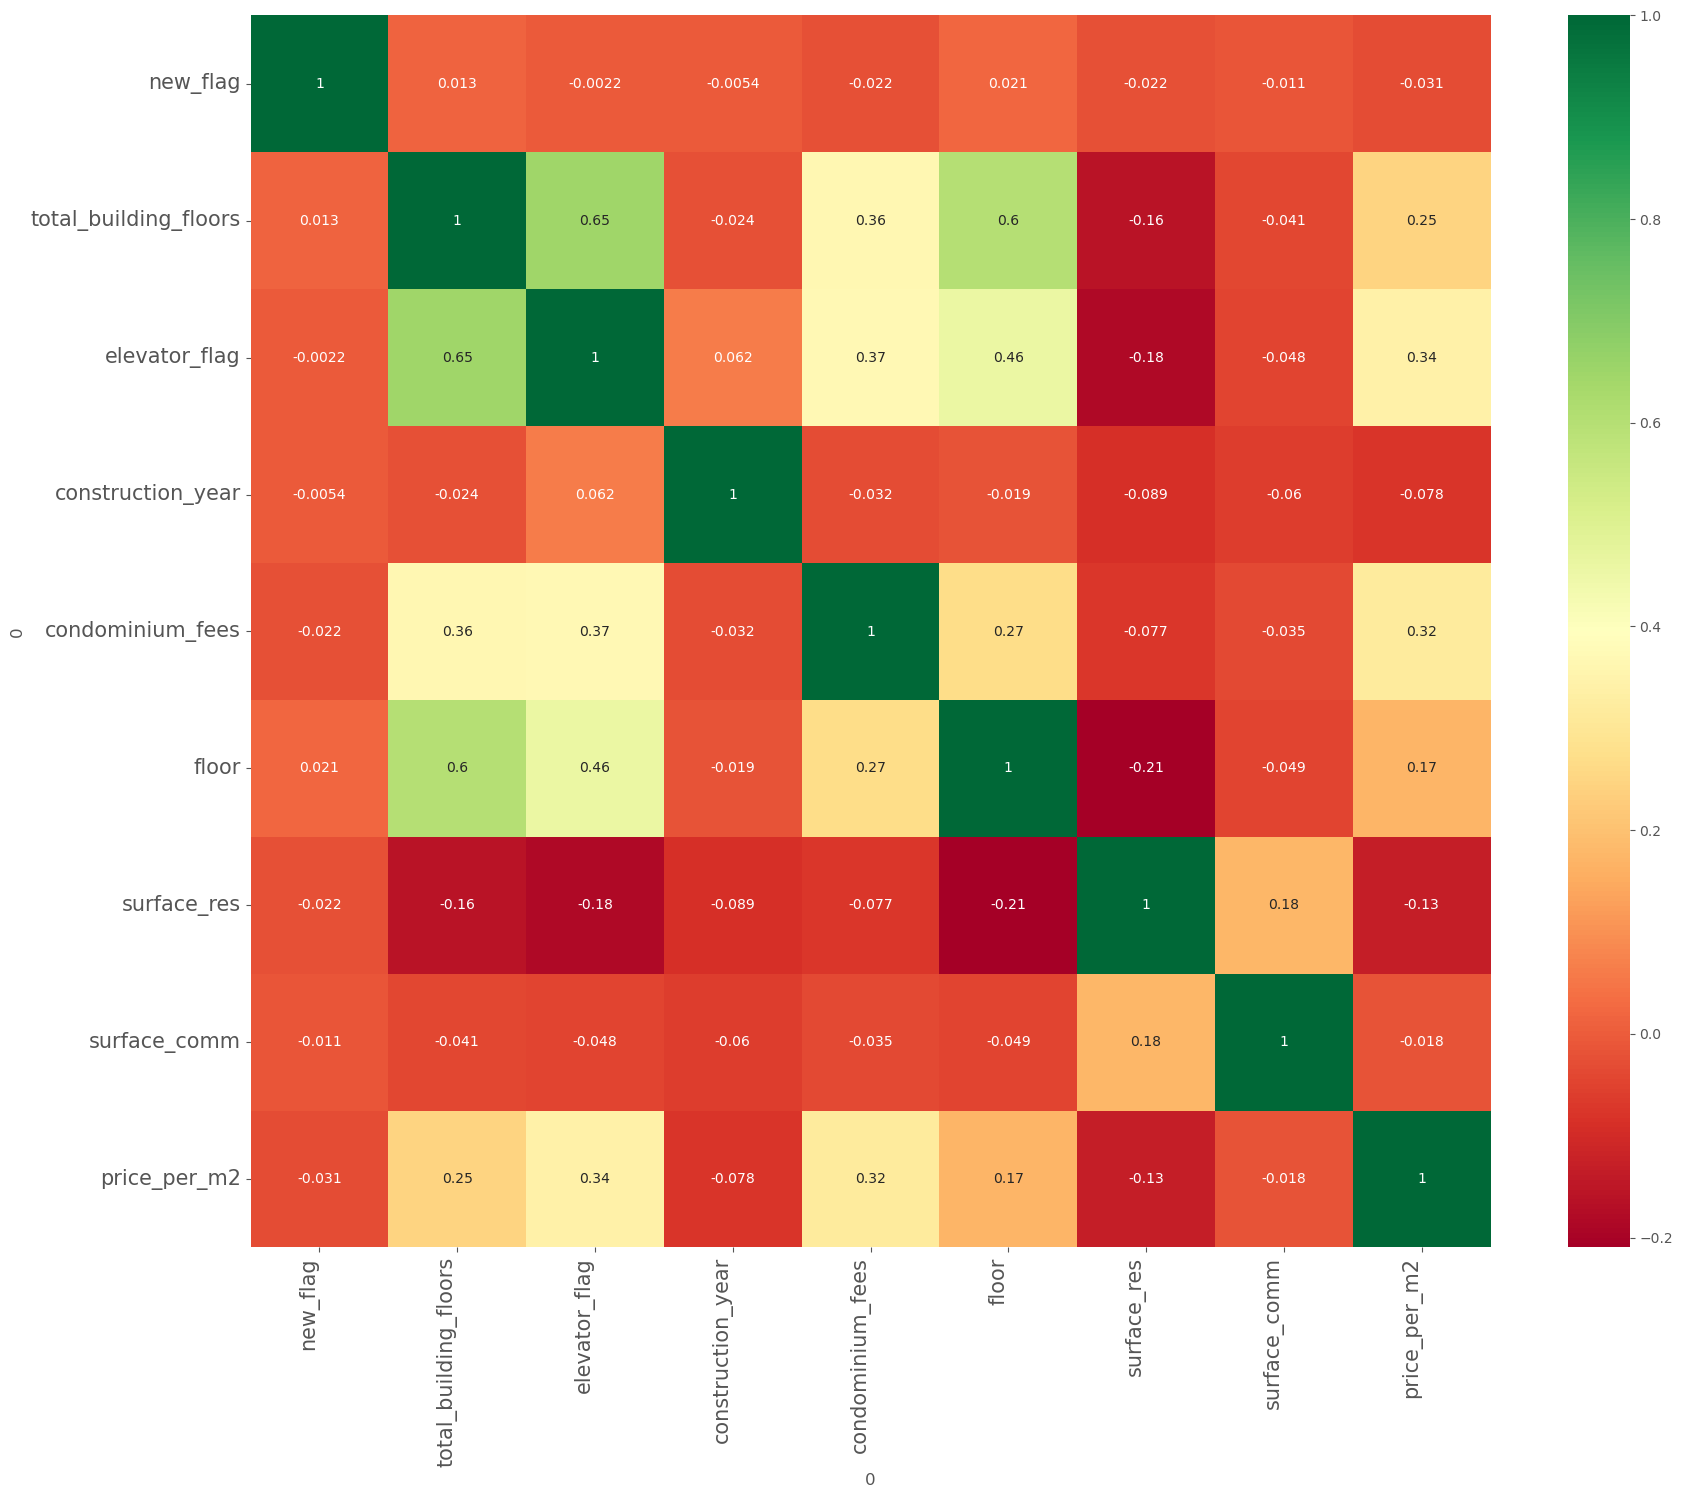

In [87]:
# Exclude 'Latitude', 'Longitude', and 'price' columns
columns_to_exclude = ['price']
df_filtered = df_final.drop(columns=columns_to_exclude)

plt.figure(figsize=(20, 16))
heatmap = sns.heatmap(df_filtered.corr(), 
                      fmt='.2g', 
                      annot=True, 
                      annot_kws={"fontsize": 10}, 
                      cmap='RdYlGn')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=15)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=15)

plt.show()


In [91]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192696 entries, 0 to 226515
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   new_flag               192696 non-null  float64
 1   price                  192696 non-null  int64  
 2   total_building_floors  192696 non-null  float64
 3   elevator_flag          192696 non-null  int64  
 4   construction_year      192696 non-null  float64
 5   condominium_fees       192696 non-null  float64
 6   ownership              192696 non-null  object 
 7   floor                  192696 non-null  float64
 8   typology               192696 non-null  object 
 9   visibility             192696 non-null  object 
 10  Region                 192696 non-null  object 
 11  surface_res            192696 non-null  float64
 12  surface_comm           17111 non-null   float64
 13  price_per_m2           192696 non-null  float64
 14  Heating_Adj            192696 non-nu

In [92]:
df_final.isna().sum()

0
new_flag                      0
price                         0
total_building_floors         0
elevator_flag                 0
construction_year             0
condominium_fees              0
ownership                     0
floor                         0
typology                      0
visibility                    0
Region                        0
surface_res                   0
surface_comm             175585
price_per_m2                  0
Heating_Adj                   0
Air_Conditioning_Adj          0
Condition                     0
room_Adj                      0
Property_Class                0
bathroom_Adj                  0
energy_efficiency_Adj         0
dtype: int64

In [93]:
df_final.to_csv('data_clean.csv', index=False)